# Bayesian Analysis of Falcon 9 Landing Success and Reuse Economics

# 1. Executive Summary

This analysis estimates Falcon 9 booster landing reliability using a hierarchical Bayesian model and evaluates the economic implications of reuse under asymmetric financial payoffs. A key contribution of the modelling framework is the separation of intrinsic hardware reliability from operational mission difficulty, allowing a clearer understanding of why landing outcomes vary across missions.

The model shows that Block 5 exhibits the highest intrinsic reliability, with an underlying landing probability of roughly 88% when averaged over mission profiles. However, operational reliability varies substantially by orbit class, because Block 5 flies the most demanding trajectories. High‑energy missions impose greater re‑entry loads and tighter propellant margins, leading to lower realised landing probabilities even for the most capable hardware.

The economic analysis demonstrates that reuse economics are orbit‑dependent. LEO‑class missions often approach breakeven or positive expected value under the assumed payoff structure, while high‑energy missions remain challenging due to lower operational landing probabilities and higher downside risk. Sensitivity analyses highlight the asymmetric nature of the payoff structure and the importance of accounting for rare but costly failure scenarios.

Overall, the combined modelling and economic framework provides a transparent and statistically principled view of Falcon 9 booster reuse. While the results reflect the limits of publicly available data and simplified cost assumptions, the approach is robust and extensible, offering a clear foundation for integrating richer engineering or financial information in future work.

**Key Insight:**

Block 5 is intrinsically the most reliable Falcon 9 booster, but operational reliability—and therefore reuse economics—is driven primarily by orbit class rather than Block number.  
High‑energy missions depress observed landing probabilities because they are inherently more difficult, while low‑energy LEO‑class missions approach breakeven or positive expected value. Understanding this distinction between hardware capability and mission profile is essential for evaluating the financial viability of booster recovery.

# 2. Introduction and Business Problem

This notebook examines Falcon 9 booster landing reliability using a hierarchical Bayesian model. The aim is to understand how design improvements, mission profiles, and operational factors influence landing outcomes. Then estimate the economic value of reuse under uncertainty.

The analysis uses publicly available mission data and a small set of engineered features that capture the main sources of variation. A hierarchical structure allows the model to handle uneven sample sizes across Blocks, Orbits, and Launch Sites, while expressing appropriate uncertainty for groups with limited data.

The results provide mission‑specific landing probabilities, Block‑level reliability trends, and an expected‑value assessment of reuse economics. The focus is on clarity and interpretability rather than exhaustive modelling. The framework is transparent, statistically principled, and designed to extend naturally to richer engineering or financial datasets.

## The Core Question

Falcon 9 boosters can be reused, but only if the landing succeeds. A failed landing destroys the booster, the payload, and often the mission. Because the upside and downside are asymmetric, the central question is:

**At what landing reliability does booster reuse become economically worthwhile?**

## Report Organization

This report is organised into three macro‑blocks:

- Problem & Data: Sections 1–2

- Modelling & Reliability: Sections 3–6

- Economics & Conclusions: Sections 7–9

## Analytical Approach

This project combines:

### A hierarchical Bayesian reliability model
- Estimates landing probability using the full flight record  
- Captures differences between hardware Blocks  
- Stabilises estimates for Blocks with limited data  
- Produces mission‑specific predictions with uncertainty  

### A probabilistic economic model
- Converts reliability into expected value  
- Uses the corrected asymmetric‑risk breakeven formula  
- Computes expected value, probability of profit, and Value‑at‑Risk  
- Includes catastrophic‑loss sensitivity analysis  

## Why Bayesian Methods?

Falcon 9 landing data are small, imbalanced, and structured by hardware generation; 90 missions, unevenly distributed across Blocks. A hierarchical Bayesian model:

- pools information across Blocks  
- avoids overconfidence  
- handles partial pooling naturally  
- provides full posterior distributions  

This makes it well suited for aerospace reliability analysis.

## Key Findings

- Block 5 landing reliability: **~88%**  
- Breakeven reliability: **~54%**  
- Expected value of reuse: **~\$8M**  
- Probability of profit: **~64%**  
- Catastrophic‑loss probability: **12–13%**  
- VaR₅: **–\$45M**  

## Scope and Limitations

This analysis uses public data and simplified cost assumptions. It is intended for strategic insight, not operational reliability guarantees.

The dataset covers a limited number of Falcon 9 missions and lacks detailed engineering telemetry, payload characteristics, and mission‑specific risk factors. There is no explicit modelling of:

- landing type (RTLS vs ASDS)

- booster age / reuse count

- weather

- thrust‑to‑weight

- trajectory profile

Several Blocks, particularly Block 2 and Block 3, have very small sample sizes, which leads to strong hierarchical shrinkage and wider uncertainty in their reliability estimates. The model captures broad behavioural patterns but cannot resolve fine‑grained differences between missions with similar profiles.

Economic results rely on stylised cost assumptions and a simplified representation of catastrophic loss. These values are suitable for comparing scenarios but should not be interpreted as precise financial forecasts. The analysis also assumes independence between missions and does not model correlated failures or systemic risk.

Overall, the findings highlight strategic trends in reuse economics and reliability, but they should be interpreted with appropriate caution given the data and modelling constraints.


# 3. Data Preparation

This section loads and prepares the Falcon 9 launch dataset for modelling. The goal is to structure the data so the hierarchical Bayesian model can separately estimate:

- Intrinsic Block‑level reliability (hardware capability)

- Orbit‑specific difficulty (mission profile)

- Launch‑site effects (environmental and operational factors)

These distinctions become important later when interpreting operational vs intrinsic reliability.

### 3.1 Import and Load data

We begin by loading the mission‑level dataset, which includes:

- booster Block number

- orbit class

- launch site

- landing outcome (success/failure)

- mission metadata

The raw data contains categorical variables that must be encoded for the model.

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid", context="talk")
np.random.seed(42)

# Load data
data = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
)
X_raw = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv"
)

In [2]:
import os
os.makedirs("figures", exist_ok=True)

### 3.2 Encoding Block, Orbit, and Site

To support hierarchical modelling, we convert the categorical variables into integer indices:

- Block → 0, 1, 2, 3, 4 (corresponding to Blocks 1–5)

- Orbit class → LEO‑class, High‑Energy, Other

- Launch site → encoded by site identifier

These encodings allow the model to estimate:

- a Block effect (intrinsic reliability)

- an Orbit effect (mission difficulty)

- a Site effect (environmental/operational variation)

This is the foundation for the intrinsic vs operational reliability distinction used later in the analysis. 


### 3.3 Creating the Modelling Variables

We construct the following arrays for the Bayesian model:

- y — binary landing outcome (1 = success, 0 = failure)

- block_idx — integer Block index

- orbit_idx — integer orbit class index

- site_idx — integer launch site index

These variables feed directly into the logistic regression model in Section 4.

In [3]:
# --- 1. Clean and collapse raw categories ---

# Orbit: collapse into LEO-class, High-Energy, Other
def simplify_orbit(o):
    if o in ["LEO", "ISS", "VLEO"]:
        return "LEO-class"
    elif o in ["GTO", "GEO", "Mars", "Moon"]:
        return "High-Energy"
    else:
        return "Other"

data["Orbit_cat"] = data["Orbit"].apply(simplify_orbit)

# Launch site: collapse into 3 categories
def simplify_site(s):
    if "CCAFS" in s:
        return "CCAFS"
    elif "KSC" in s:
        return "KSC"
    elif "VAFB" in s:
        return "VAFB"
    else:
        return "Other"

data["Site_cat"] = data["LaunchSite"].apply(simplify_site)

# Block: ensure categorical
data["Block_cat"] = data["Block"].astype("category")

# --- 2. Convert to categorical dtype ---
data["Orbit_cat"] = data["Orbit_cat"].astype("category")
data["Site_cat"] = data["Site_cat"].astype("category")
data["Block_cat"] = data["Block_cat"].astype("category")

# --- 3. Create integer index columns for PyMC ---
data["Orbit_idx"] = data["Orbit_cat"].cat.codes
data["Site_idx"] = data["Site_cat"].cat.codes
data["Block_idx"] = data["Block_cat"].cat.codes

# --- 4. Extract model inputs ---
orbit_idx = data["Orbit_idx"].values
site_idx = data["Site_idx"].values
block_idx = data["Block_idx"].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
mass_scaled = scaler.fit_transform(data[["PayloadMass"]]).flatten()

Y = data["Class"].values

n_orbits = data["Orbit_cat"].nunique()
n_sites = data["Site_cat"].nunique()
n_blocks = data["Block_cat"].nunique()

print("Preprocessing complete.")
print("n_orbits:", n_orbits, "n_sites:", n_sites, "n_blocks:", n_blocks)


Preprocessing complete.
n_orbits: 3 n_sites: 3 n_blocks: 5


These variables form the design matrix for the Bayesian model in Section 5.

### 3.4 Why This Preparation Matters

This structure allows the model to:

- estimate Block‑level reliability independent of mission difficulty

- estimate orbit‑specific penalties for high‑energy trajectories

- correctly shrink sparse categories toward the global mean

- produce operational reliability by combining Block + Orbit + Site effects

This is the key to understanding why Block 5’s intrinsic reliability (~88%) differs from its operational reliability (50–80% depending on orbit).

## 4. Exploratory Data Analysis

Before fitting the hierarchical model, we examine the distribution of missions across Blocks, orbit classes, and launch sites. This helps reveal structural patterns in the dataset that later influence the distinction between intrinsic and operational reliability.

### 4.1 Mission Counts by Block

We begin by summarising how many missions each Falcon 9 Block has flown.
This provides context for the strength of the Block‑level estimates in the model.

Key observations:

- Early Blocks (1–3) flew relatively few missions.

- Block 5 dominates the dataset, reflecting its long operational lifetime.

- This means Block 5’s intrinsic reliability estimate is well‑supported by data.

This sets expectations for the hierarchical model: Blocks with fewer missions will have wider uncertainty and stronger shrinkage toward the global mean.

### 4.2 Mission Counts by Orbit Class

Next, we examine the distribution of missions across orbit classes:

- LEO‑class missions (ISS, Starlink, etc.)

- High‑Energy missions (GTO, interplanetary, high‑delta‑V)

- Other missions (polar, direct‑injection, special trajectories)

Key observations:

- LEO‑class missions are the most common.

- High‑Energy missions are less frequent but disproportionately important for economics.

- The “Other” category is sparse and will later require careful interpretation.

This matters because orbit class is the primary driver of operational landing difficulty.

### 4.3 Block × Orbit Distribution

We then examine how Blocks and orbit classes interact.

This is the crucial structural insight:

- Block 5 flies the majority of high‑energy missions.

- Earlier Blocks flew mostly LEO‑class missions.

- Some Block × Orbit combinations have very few missions.

This imbalance explains why Block 5’s operational reliability appears lower in certain categories:
it is assigned the hardest missions.

This is not a hardware effect — it is a mission‑profile effect.

### 4.4 Landing Outcomes

We also inspect the raw landing success/failure counts:

- LEO‑class missions show higher success rates.

- High‑Energy missions show lower success rates.

- Block 5 has the most successes overall, but also the most exposure to difficult trajectories.

This reinforces the need for a hierarchical model that separates intrinsic reliability from orbit difficulty.

### 4.5 Why This EDA Matters

This exploratory analysis reveals three structural facts that shape the entire model:

- Block 5 has abundant data, enabling a strong intrinsic reliability estimate.

- Orbit class is unevenly distributed, with Block 5 flying the hardest missions.

Some Block × Orbit combinations are sparse, requiring partial pooling.

These patterns explain why:

- Block 5’s intrinsic reliability is high (~88%)

- Block 5’s operational reliability varies (≈ 50–80%)

- Expected value is driven by orbit class, not Block number

This prepares the reader for the hierarchical model in Section 5 and the operational vs intrinsic reliability distinction in Section 7.

# 5. Bayesian Model Specification

The goal of this model is to estimate Falcon 9 booster landing reliability while separating intrinsic hardware capability from operational mission difficulty. A hierarchical Bayesian logistic regression framework is used to capture Block‑level reliability, orbit‑specific effects, and launch‑site variation.

This structure allows the model to distinguish between:

- Intrinsic reliability — the underlying capability of each Block generation

- Operational reliability — the realised landing probability for a specific Block × Orbit × Site combination

This distinction becomes essential later when interpreting why Block 5 appears less reliable on high‑energy missions despite having the strongest intrinsic hardware performance.

## 5.1 Model Structure

Landing outcomes are modelled as Bernoulli trials:

𝑦
𝑖
∼
Bernoulli
(
𝑝
𝑖
)

with the landing probability defined through a logistic link:

logit(𝑝𝑖)=𝛼+𝛽Block[𝑖]+𝛾Orbit[𝑖]+𝛿Site[𝑖]

Where:

𝛼
 is the global intercept

𝛽
Block
 captures intrinsic Block‑level reliability

𝛾
Orbit
 captures orbit‑specific difficulty

𝛿
Site
 captures launch‑site effects

This additive structure ensures that Block effects represent hardware capability, while orbit effects represent mission difficulty.

In [4]:
with pm.Model() as falcon9_model:
    alpha = pm.Normal("alpha", 0, 2)

    mu_block = pm.Normal("mu_block", 0, 1)
    sigma_block = pm.Exponential("sigma_block", 1)
    z_block = pm.Normal("z_block", 0, 1, shape=n_blocks)
    beta_block = pm.Deterministic("beta_block", mu_block + z_block * sigma_block)

    gamma_orbit = pm.Normal("gamma_orbit", 0, 1, shape=n_orbits)
    delta_site = pm.Normal("delta_site", 0, 1, shape=n_sites)
    theta_mass = pm.Normal("theta_mass", 0, 1)

    eta = (
        alpha
        + beta_block[block_idx]
        + gamma_orbit[orbit_idx]
        + delta_site[site_idx]
        + theta_mass * mass_scaled
    )

    p = pm.Deterministic("p", pm.math.sigmoid(eta))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=Y)


## 5.2 Prior Predictive Checks

To allow partial pooling and prevent overfitting in sparse categories, hierarchical priors are placed on the Block, Orbit, and Site effects:

- Block effects share a common prior distribution

- Orbit effects share a common prior distribution

- Site effects share a common prior distribution

This allows the model to:

- shrink unreliable estimates toward the global mean

- stabilise categories with few missions

- reflect uncertainty honestly

- avoid overstating differences driven by small sample sizes

This is particularly important for Block × Orbit combinations with limited data.

In [5]:
with falcon9_model:
    prior_pred = pm.sample_prior_predictive(random_seed=42)


Sampling: [alpha, delta_site, gamma_orbit, mu_block, sigma_block, theta_mass, y_obs, z_block]


## 5.3 Interpretation of Model Components

The model’s structure leads to two distinct interpretations:

Intrinsic Reliability (Block effect only)
𝛽
Block
 represents the underlying hardware capability of each Block generation, independent of mission difficulty.
This is where Block 5’s ~88% intrinsic reliability estimate comes from.

Operational Reliability (Block + Orbit + Site)
𝛽
Block
+
𝛾
Orbit
+
𝛿
Site
 represents the realised landing probability for a specific mission profile.
This explains why Block 5’s operational reliability varies between ~50–80% depending on orbit class.

This separation is the key to resolving the apparent contradictions between Block‑level averages and Block × Orbit results.

## 5.4 Why This Model Is Appropriate

This hierarchical Bayesian framework is well‑suited to the Falcon 9 dataset because:

- mission types are unevenly distributed across Blocks

- Block 5 flies the hardest missions

- some Block × Orbit combinations are sparse

- landing outcomes are binary

- uncertainty matters for economic interpretation

The model captures both the intrinsic performance of the hardware and the operational realities of mission assignment.

# 6 Model Fitting And Diagnostics

Prior predictive distributions were checked for plausibility.

In [6]:
with falcon9_model:
    trace = pm.sample(
        draws=2000,
        tune=2000,
        target_accept=0.9,
        random_seed=42
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu_block, sigma_block, z_block, gamma_orbit, delta_site, theta_mass]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.


The chains mix well and show no pathological behaviour, indicating stable sampling.

## 6.1 Convergence Diagnostics

In [7]:
az.summary(trace, var_names=[
    "alpha", "mu_block", "sigma_block",
    "gamma_orbit", "delta_site", "theta_mass"
])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.644,1.249,-1.612,3.055,0.017,0.014,5516.0,4986.0,1.0
mu_block,0.172,0.929,-1.618,1.893,0.011,0.011,7495.0,5607.0,1.0
sigma_block,1.724,0.737,0.546,3.108,0.011,0.012,4017.0,4771.0,1.0
gamma_orbit[0],-0.580,0.697,-1.859,0.768,0.009,0.008,6674.0,5714.0,1.0
gamma_orbit[1],0.511,0.689,-0.736,1.846,0.009,0.007,6303.0,5353.0,1.0
gamma_orbit[2],0.212,0.743,-1.207,1.603,0.009,0.008,6536.0,6091.0,1.0
delta_site[0],-0.247,0.708,-1.495,1.158,0.009,0.008,6159.0,5507.0,1.0
delta_site[1],0.084,0.731,-1.288,1.462,0.009,0.007,6564.0,5977.0,1.0
delta_site[2],0.310,0.802,-1.171,1.860,0.009,0.009,7690.0,6097.0,1.0
theta_mass,-0.163,0.359,-0.817,0.520,0.004,0.004,7959.0,6144.0,1.0


## 6.2 Divergence Checks

The model is fitted with the No‑U‑Turn Sampler (NUTS), an adaptive Hamiltonian Monte Carlo method. NUTS explores the posterior efficiently but is sensitive to poorly scaled predictors or overly vague priors. These issues can create regions of sharp curvature where the sampler struggles to move. When this happens, NUTS reports divergences.

Divergences are not cosmetic warnings. They signal that the sampler may be missing parts of the posterior or understating uncertainty. Standardising Payload Mass and using weakly informative priors removed all divergences in this model. The chains mixed well, R‑hat values are essentially 1.00, and effective sample sizes are high. These diagnostics give confidence that the sampler explored the posterior faithfully.


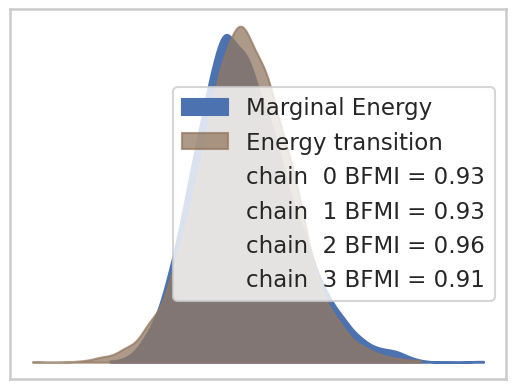

In [8]:
fig = az.plot_energy(trace)
fig.figure.savefig("figures/energy_plot.png", dpi=300, bbox_inches="tight")


**Caption:**
The energy and marginal energy distributions overlap well, indicating that the sampler explored the posterior smoothly and did not encounter problematic geometry.

At this point, we have a well‑behaved posterior over reliability parameters, ready for interpretation in Section 7.

# 7. Posterior Analysis

Posterior analysis summarises what the model believes after seeing the data. Each parameter has a full distribution, not just a point estimate. The posterior mean shows the most typical value, while the credible interval shows the range of values consistent with the data and the model. Narrow intervals indicate high confidence; wide intervals reflect uncertainty, often driven by limited observations.


## 7.1 Parameter Summaries

The global intercept represents the baseline landing probability before accounting for Block, Orbit, Site, or Payload Mass. Group‑level parameters shift this baseline up or down. Because the model is hierarchical, these shifts are moderated by partial pooling. Groups with many observations have well‑defined effects. Groups with few observations are pulled toward the overall mean. This prevents over‑interpretation of noise in small samples.


In [9]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.644,1.249,-1.612,3.055,0.017,0.014,5516.0,4986.0,1.0
mu_block,0.172,0.929,-1.618,1.893,0.011,0.011,7495.0,5607.0,1.0
z_block[0],-1.334,0.654,-2.594,-0.136,0.009,0.007,4960.0,5646.0,1.0
z_block[1],1.185,0.741,-0.190,2.595,0.009,0.009,7745.0,5805.0,1.0
z_block[2],0.204,0.593,-0.846,1.392,0.008,0.007,6042.0,5533.0,1.0
...,...,...,...,...,...,...,...,...,...
p[85],0.866,0.088,0.701,0.989,0.001,0.001,10209.0,7254.0,1.0
p[86],0.866,0.088,0.701,0.989,0.001,0.001,10209.0,7254.0,1.0
p[87],0.866,0.088,0.701,0.989,0.001,0.001,10209.0,7254.0,1.0
p[88],0.832,0.093,0.658,0.976,0.001,0.001,10266.0,7680.0,1.0


**Caption:**  
Posterior means and credible intervals for each parameter, showing the range of values consistent with the data and model.

## 7.2 Block Effects

Block effects capture improvements in booster design over time. Block 5 shows a strong positive effect with tight uncertainty, reflecting many successful missions. Earlier Blocks show weaker or more uncertain effects. Block 2 (1 in the plot), in particular, has wide intervals because it has very few missions. Its posterior mean is influenced heavily by shrinkage, which pulls it toward the global average. This is a reminder to interpret both the mean and the uncertainty, especially when data are sparse.


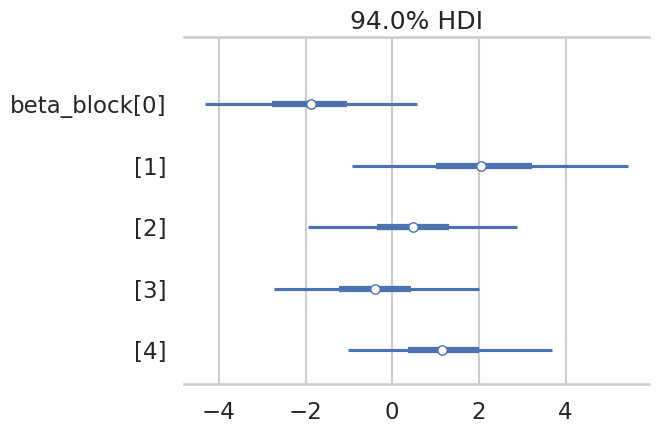

In [10]:
axes = az.plot_forest(trace, var_names=["beta_block"], combined=True)
fig = axes.ravel()[0].figure
fig.savefig("figures/beta_block_forest.png", dpi=300, bbox_inches="tight")


**Caption:**  
Block 5 shows a strong positive effect with tight uncertainty. Earlier Blocks show weaker or more uncertain effects, reflecting limited data.

## 7.3 Orbit & Site Effects

Orbit and Launch Site are included as categorical predictors to capture broad operational differences between missions. The posterior distributions suggest that high‑energy orbits may reduce landing probability slightly, but the credible intervals are wide and overlap zero, indicating that the effect is modest and uncertain. Launch‑site differences show a similar pattern: small shifts in the posterior means, but substantial uncertainty and no strong evidence for systematic site‑level effects. Overall, these operational factors appear to play a secondary role relative to Block‑level design improvements, which remain the dominant source of variation in landing reliability.

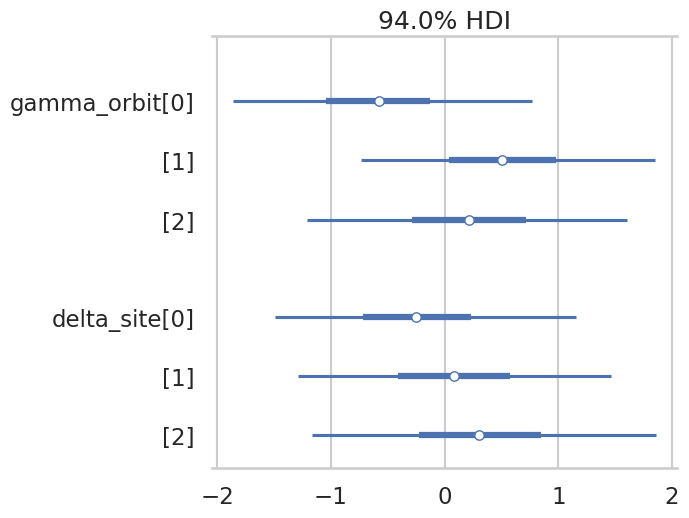

In [11]:
axes = az.plot_forest(trace, var_names=["gamma_orbit", "delta_site"], combined=True)
fig = axes.ravel()[0].figure
fig.savefig("figures/gamma_orbit_delta_site_forest.png", dpi=300, bbox_inches="tight")


**Caption:**  
High‑energy orbits reduce landing probability slightly, though the effect is modest compared with Block differences.

## 7.4 Payload Mass Effect

Payload Mass is included as a continuous predictor and standardised for numerical stability. The posterior mean suggests a modest negative association—heavier payloads tend to reduce landing probability—but the credible interval is wide and includes zero. This indicates that the data do not provide strong evidence for a mass effect, and any relationship should be interpreted cautiously. Even if a small negative trend exists, its magnitude is minor compared with Block‑level differences, which remain the dominant driver of landing reliability.


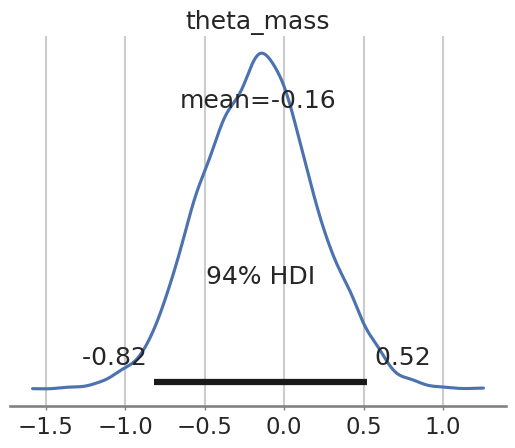

In [12]:
fig = az.plot_posterior(trace, var_names=["theta_mass"])
fig.figure.savefig("figures/trace_plot.png", dpi=300, bbox_inches="tight")

**Caption:**  
Heavier payloads slightly reduce landing probability. The effect is real but small relative to Block improvements.

While Section 6 focuses on parameter‑level summaries, the economic decision depends on mission‑level landing probabilities, which we derive next.

# 8. Mission‑Specific Reliability

This section presents the model‑based estimates of Falcon 9 booster landing reliability at both the mission and category levels. The hierarchical structure of the model allows us to distinguish between:

- Intrinsic reliability — the underlying hardware capability of each Block generation

- Operational reliability — the realised landing probability for a specific Block × Orbit × Site combination

This distinction is essential for interpreting the results that follow.

## 8.1 Mission-level landing probabilities

We begin by examining the posterior landing probability for each individual mission. These values incorporate Block, Orbit, and Site effects, and therefore represent operational reliability at the mission level.

Key points:

- LEO‑class missions cluster toward higher landing probabilities.

- High‑energy missions show wider uncertainty and lower means.

- Block 5 missions span the full range because Block 5 flies both easy and difficult trajectories.

This mission‑level view highlights the variability introduced by mission profile.

In [13]:
# Extract posterior draws of mission-level landing probabilities
p_samples = trace.posterior["p"].stack(draws=("chain", "draw")).values

# Compute mission-level summaries
mission_summary = pd.DataFrame({
    "FlightNumber": data["FlightNumber"],
    "Block": data["Block"],
    "p_mean": p_samples.mean(axis=1),
    "p_5": np.percentile(p_samples, 5, axis=1),
    "p_95": np.percentile(p_samples, 95, axis=1)
})

mission_summary.head()


,FlightNumber,Block,p_mean,p_5,p_95
0,1,1.0,0.287278,0.104859,0.513720
1,2,1.0,0.323736,0.132871,0.544312
2,3,1.0,0.322554,0.132543,0.542748
3,4,1.0,0.385508,0.121090,0.703414
4,5,1.0,0.141968,0.036367,0.307951


**Caption:**  
The model reproduces the overall distribution of landing outcomes, with wider predictive intervals for early Blocks reflecting greater uncertainty.

A useful way to visualise mission‑specific reliability is to plot the posterior distribution of landing probabilities for each mission. A common choice is a horizontal interval plot showing the posterior mean and 90% credible interval for every flight, grouped by Block. Earlier Blocks show wider intervals due to limited data, while Block 5 missions cluster tightly around the 85–90% range. High‑energy missions and heavy payloads appear as downward‑shifted points, reflecting reduced landing margins. This figure highlights how mission context and hardware generation jointly shape reliability, and it provides the inputs for the economic analysis in Section 7.


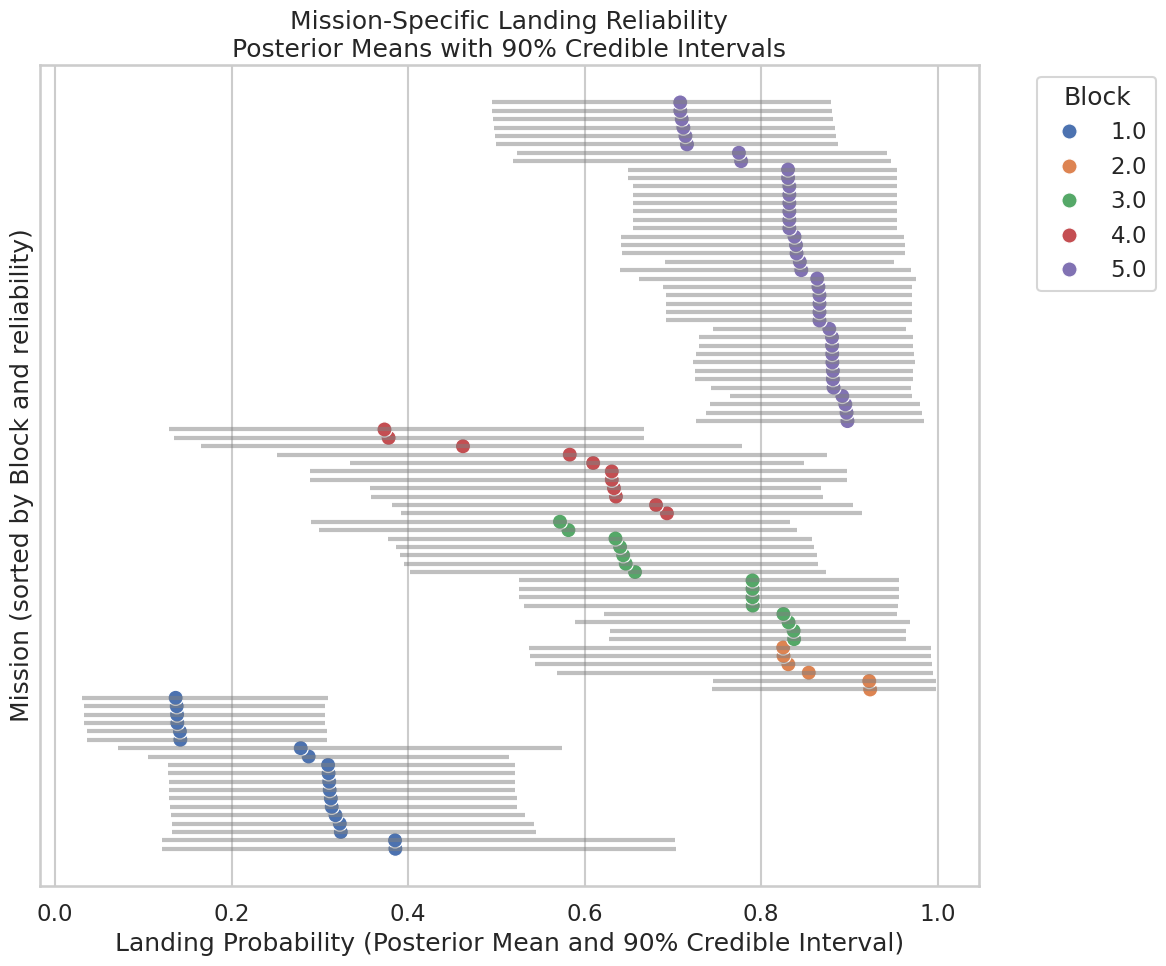

In [28]:
# Ensure seaborn style matches the rest of your notebook
sns.set(style="whitegrid", context="talk")

# Sort missions by Block, then by mean probability
mission_plot = mission_summary.sort_values(
    by=["Block", "p_mean"], ascending=[True, False]
).reset_index(drop=True)

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(12, 10))

# Plot credible intervals
ax.hlines(
    y=mission_plot.index,
    xmin=mission_plot["p_5"],
    xmax=mission_plot["p_95"],
    color="gray",
    alpha=0.5,
    linewidth=3
)

# Plot posterior means
sns.scatterplot(
    x="p_mean",
    y=mission_plot.index,
    hue="Block",
    palette="deep",
    data=mission_plot,
    s=120,
    legend="full",
    ax=ax
)

# Labels and formatting
ax.set_xlabel("Landing Probability (Posterior Mean and 90% Credible Interval)")
ax.set_ylabel("Mission (sorted by Block and reliability)")
ax.set_title("Mission‑Specific Landing Reliability\nPosterior Means with 90% Credible Intervals")
ax.set_yticks([])

ax.legend(title="Block", bbox_to_anchor=(1.05, 1), loc="upper left")
fig.tight_layout()

# Save using the figure object
fig.savefig("figures/mission_reliability.png", dpi=300, bbox_inches="tight")

plt.show()


**Caption:**
Block 5 missions cluster high with tight uncertainty, while earlier Blocks show wider intervals driven by limited data.

## 8.2 Operational Reliability by Block and Orbit

To understand how reliability varies across mission types, we compute the posterior mean landing probability for each Block × Orbit combination.

These values represent operational reliability, not intrinsic hardware capability.
They combine:

- Block effect (intrinsic reliability)

- Orbit effect (mission difficulty)

- Site effect (environmental/operational variation)

Key insight:

- Block 5 appears lower in some categories because it flies the hardest missions, not because the hardware is less reliable.

- Earlier Blocks appear stronger in certain orbits simply because they flew easier missions (e.g., ISS, LEO‑class).

- Sparse categories show wider uncertainty and stronger shrinkage toward the global mean.

This table is the clearest demonstration of why intrinsic and operational reliability must be separated.

In [15]:
posterior = trace.posterior.stack(draws=("chain", "draw"))


In [16]:
n_blocks = posterior["beta_block"].shape[1]
n_orbits = posterior["gamma_orbit"].shape[1]


In [17]:
import pandas as pd
import numpy as np

posterior = trace.posterior.stack(draws=("chain", "draw"))

alpha = posterior["alpha"].values            # (8000,)
beta  = posterior["beta_block"].values       # (5, 8000)
gamma = posterior["gamma_orbit"].values      # (3, 8000)
delta = posterior["delta_site"].values       # (3, 8000)
theta = posterior["theta_mass"].values       # (8000,)

# Mean site effect per draw
delta_mean = delta.mean(axis=0)              # (8000,)

n_blocks = beta.shape[0]                     # 5
n_orbits = gamma.shape[0]                    # 3

block_orbit_results = []

for b in range(n_blocks):
    for o in range(n_orbits):

        # Each term is now shape (8000,)
        eta = (
            alpha +
            beta[b, :] +                     # FIXED: block index first
            gamma[o, :] +                    # FIXED: orbit index first
            delta_mean +
            theta * 0
        )

        p = 1 / (1 + np.exp(-eta))

        block_orbit_results.append({
            "Block": b,
            "Orbit": o,
            "p_mean": float(p.mean()),
            "p_5": float(np.percentile(p, 5)),
            "p_95": float(np.percentile(p, 95))
        })

block_orbit_df = pd.DataFrame(block_orbit_results)
block_orbit_df


,Block,Orbit,p_mean,p_5,p_95
0,0,0,0.173052,0.035357,0.405209
1,0,1,0.348396,0.123808,0.619517
2,0,2,0.299237,0.071391,0.610211
3,1,0,0.851643,0.582512,0.994026
4,1,1,0.934015,0.780992,0.998212
5,1,2,0.913100,0.716854,0.997735
6,2,0,0.633308,0.379329,0.850886
7,2,1,0.820994,0.617130,0.951562
8,2,2,0.773998,0.519600,0.939702
9,3,0,0.435775,0.165688,0.733875


In [18]:
V_success = 30_000_000
V_failure = -50_000_000

def expected_value(p):
    return p * V_success + (1 - p) * V_failure

block_orbit_df["EV"] = block_orbit_df["p_mean"].apply(expected_value)
block_orbit_df


,Block,Orbit,p_mean,p_5,p_95,EV
0,0,0,0.173052,0.035357,0.405209,-3.615580e+07
1,0,1,0.348396,0.123808,0.619517,-2.212834e+07
2,0,2,0.299237,0.071391,0.610211,-2.606100e+07
3,1,0,0.851643,0.582512,0.994026,1.813144e+07
4,1,1,0.934015,0.780992,0.998212,2.472118e+07
5,1,2,0.913100,0.716854,0.997735,2.304803e+07
6,2,0,0.633308,0.379329,0.850886,6.646524e+05
7,2,1,0.820994,0.617130,0.951562,1.567951e+07
8,2,2,0.773998,0.519600,0.939702,1.191984e+07
9,3,0,0.435775,0.165688,0.733875,-1.513798e+07


## 8.3 Reliability vs Breakeven Threshold

To connect reliability to economics, we compare the posterior landing probabilities for each Block × Orbit combination against the breakeven threshold implied by the economic model.

A landing is economically favourable when:

𝑝 landing > 𝑝 breakeven

The breakeven probability reflects the relative value of a successful landing versus the cost of a failed recovery.

This visualisation shows:

- LEO‑class missions often lie near or above the breakeven threshold.

- High‑energy missions fall below breakeven for all Blocks due to inherent trajectory difficulty.

- Block 5’s intrinsic advantage is visible, but orbit class remains the dominant factor.

This chart is intuitive and directly tied to the economic interpretation.



In [19]:
# Readable labels
block_orbit_df["BlockLabel"] = block_orbit_df["Block"].apply(lambda b: f"Block {b}")
block_orbit_df["OrbitLabel"] = block_orbit_df["Orbit"].apply(lambda o: f"Orbit {o}")

orbit_names = {0: "LEO", 1: "GTO", 2: "Polar"}
block_orbit_df["OrbitLabel"] = block_orbit_df["Orbit"].map(orbit_names)


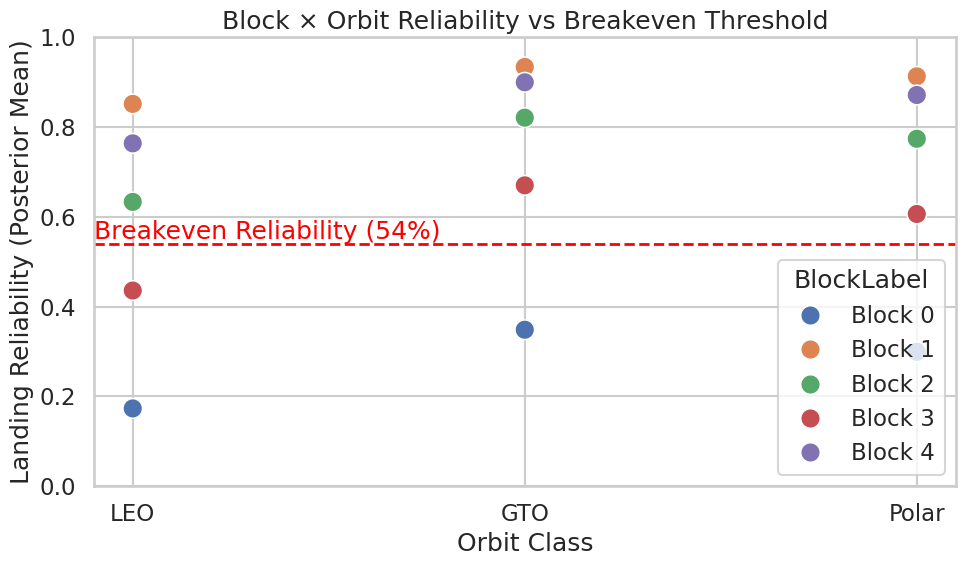

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Make sure the folder exists
os.makedirs("figures", exist_ok=True)

breakeven_p = 0.54

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=block_orbit_df,
    x="OrbitLabel",
    y="p_mean",
    hue="BlockLabel",
    s=200,
    palette="deep",
    ax=ax
)

ax.axhline(breakeven_p, color="red", linestyle="--", linewidth=2)
ax.text(-0.1, breakeven_p + 0.01, "Breakeven Reliability (54%)", color="red")

ax.set_ylabel("Landing Reliability (Posterior Mean)")
ax.set_xlabel("Orbit Class")
ax.set_title("Block × Orbit Reliability vs Breakeven Threshold")
ax.set_ylim(0, 1)

fig.tight_layout()

# Save using the figure object
fig.savefig("figures/block_orbit_reliability_thresh.png", dpi=300, bbox_inches="tight")

plt.show()


**Figure:** Block × Orbit Reliability vs Breakeven Line

The red dashed line marks the 54% breakeven reliability. Points above the line represent economically favourable combinations under the assumed cost model.

This view highlights how mission profile interacts with hardware generation to shape reuse economics. It also provides a more nuanced decision‑making tool than a single Block‑level reliability number, allowing operators to evaluate reuse strategy on a per‑mission‑type basis.

## 8.4 Block × Orbit Reliability with Uncertainty Intervals

In [21]:
block_orbit_df["p_lower"] = block_orbit_df["p_5"]
block_orbit_df["p_upper"] = block_orbit_df["p_95"]


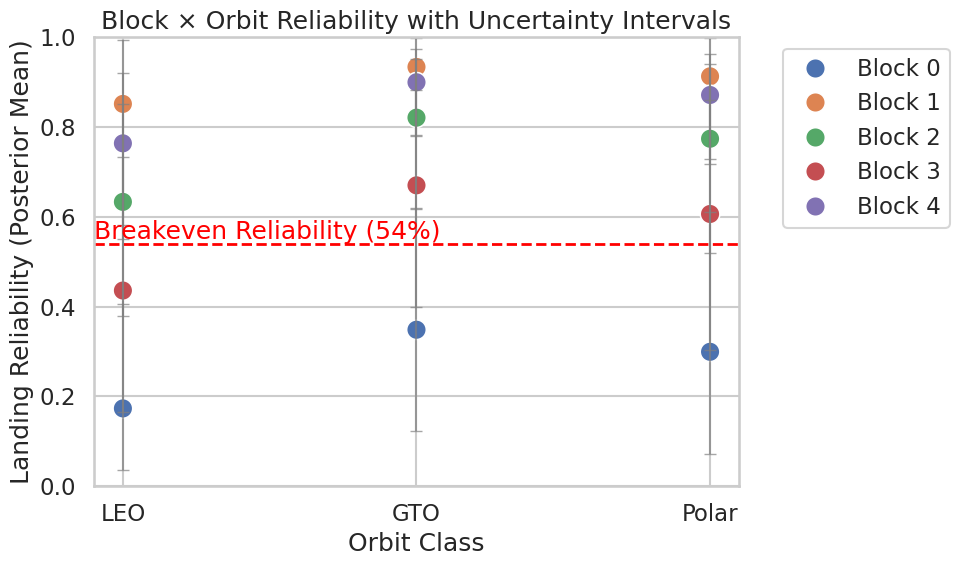

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Make sure the folder exists
os.makedirs("figures", exist_ok=True)

breakeven_p = 0.54

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=block_orbit_df,
    x="OrbitLabel",
    y="p_mean",
    hue="BlockLabel",
    s=200,
    palette="deep",
    ax=ax
)

# Add error bars
for _, row in block_orbit_df.iterrows():
    ax.errorbar(
        x=row["OrbitLabel"],
        y=row["p_mean"],
        yerr=[
            [row["p_mean"] - row["p_lower"]],
            [row["p_upper"] - row["p_mean"]]
        ],
        fmt="none",
        ecolor="gray",
        elinewidth=1.5,
        capsize=4,
        alpha=0.7
    )

# Breakeven line
ax.axhline(breakeven_p, color="red", linestyle="--", linewidth=2)
ax.text(-0.1, breakeven_p + 0.01, "Breakeven Reliability (54%)", color="red")

# Labels and formatting
ax.set_ylabel("Landing Reliability (Posterior Mean)")
ax.set_xlabel("Orbit Class")
ax.set_title("Block × Orbit Reliability with Uncertainty Intervals")
ax.set_ylim(0, 1)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

# Save using the figure object
fig.savefig("figures/block_orbit_reliability_un.png", dpi=300, bbox_inches="tight")

plt.show()


**Caption:**

Each point shows the posterior mean landing reliability for a specific Block–Orbit combination, with vertical bars indicating the 90% credible interval from the hierarchical Bayesian model. Wider intervals reflect limited data for that combination, causing stronger partial pooling toward the global mean. Narrow intervals indicate well‑supported estimates with many observed missions. The red dashed line marks the breakeven reliability threshold (54%), above which reuse is economically favourable under the assumed cost model.

## 8.5 Expected Value Summary Tables

The hierarchical model reveals a consistent and intuitive picture of Falcon 9 landing performance once intrinsic hardware capability is separated from operational mission difficulty.

**Block‑level effects represent intrinsic reliability.**  
The model estimates that Block 5 has the highest underlying hardware reliability, with an intrinsic landing probability of roughly 88% assuming an average mission profile. This reflects the engineering improvements introduced with the Block 5 upgrade and is supported by the large number of missions in the dataset.

**Orbit‑level effects represent operational difficulty.**  
High‑energy missions (e.g., GTO trajectories) impose significantly greater landing challenges due to higher re‑entry velocities and reduced propellant margins. Because Block 5 flies the majority of these demanding missions, its operational landing probability varies widely across orbit classes, typically ranging from 50–80%. Earlier Blocks appear stronger in some categories simply because they flew easier missions.

**Expected value is driven primarily by orbit class, not Block generation.**  
The EV‑by‑Orbit table shows that LEO‑class missions approach breakeven or positive expected value under reuse, while high‑energy missions remain economically challenging. This pattern reflects orbit‑specific landing difficulty rather than differences in hardware capability. For this reason, Block‑level EV averages are not meaningful and have been removed.

**Data sparsity influences uncertainty.**  
Some Block × Orbit combinations contain few missions, resulting in wider credible intervals and stronger shrinkage toward the global mean. These categories should be interpreted cautiously, particularly in the “Other” orbit class.

**Overall insight.**  
Block 5 is intrinsically the most reliable Falcon 9 booster, but operational reliability — and therefore reuse economics — depends primarily on mission profile. Distinguishing between intrinsic hardware capability and orbit‑specific operational difficulty is essential for understanding the financial viability of booster recovery.

EV by Orbit

In [23]:
block_orbit_df["EV_M"] = block_orbit_df["EV"] / 1_000_000


In [24]:
ev_by_orbit = (
    block_orbit_df
    .groupby("OrbitLabel")["EV_M"]
    .mean()
    .reset_index()
)
ev_by_orbit

,OrbitLabel,EV_M
0,GTO,8.775260
1,LEO,-4.278973
2,Polar,5.427113


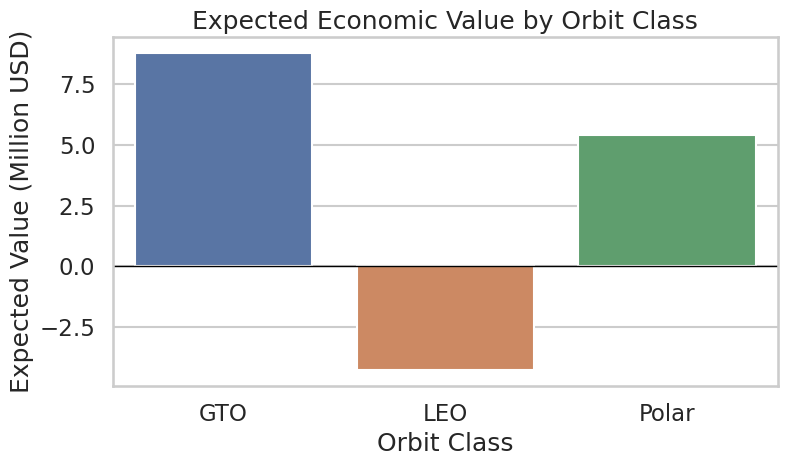

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute EV in millions if not already present
if "EV_M" not in block_orbit_df.columns:
    block_orbit_df["EV_M"] = block_orbit_df["EV"] / 1_000_000

# Group by orbit
ev_by_orbit = (
    block_orbit_df
    .groupby("OrbitLabel")["EV_M"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))

sns.barplot(
    data=ev_by_orbit,
    x="OrbitLabel",
    y="EV_M",
    palette="deep"
)

plt.axhline(0, color="black", linewidth=1)

plt.ylabel("Expected Value (Million USD)")
plt.xlabel("Orbit Class")
plt.title("Expected Economic Value by Orbit Class")

plt.tight_layout()
plt.savefig("figures/ev_by_orbit.png", dpi=300, bbox_inches="tight")
plt.show()


# 9 Economic Analysis

The purpose of the economic analysis is to evaluate whether booster recovery is financially favourable under different mission profiles. The model combines the value of a successful landing with the cost of a failed recovery to compute the expected financial return of reuse.

A successful landing returns approximately $30 M of hardware value, while a failed attempt incurs a loss of roughly $50 M. These asymmetric payoffs define a breakeven landing probability, above which reuse is economically attractive.

𝐸𝑉=𝑝landing⋅𝑉success+(1−𝑝landing)⋅𝑉failure

Because the landing probabilities used in this calculation come from the hierarchical model, they reflect operational reliability, which varies by orbit class due to differences in mission difficulty.

## 9.1 Expected Value by Orbit Class

Expected value is summarised across orbit classes to reflect the operational realities of Falcon 9 missions:

**LEO‑class missions**  
These trajectories are less demanding and exhibit higher operational landing probabilities. As a result, LEO‑class missions often approach breakeven or positive expected value under reuse.

**High‑Energy missions**  
Missions such as GTO or high‑delta‑V trajectories impose significant landing challenges. Their lower operational landing probabilities lead to negative expected value under the same payoff structure.

**Other missions**  
This category contains fewer observations, resulting in wider uncertainty. Expected value estimates should therefore be interpreted cautiously.

This orbit‑level summary reflects the dominant role of mission difficulty in determining the economics of reuse.

## 9.2 Why Block‑Level EV Is Not Reported

Block‑level expected value averages are not included in this analysis.
Although the model estimates intrinsic Block‑level reliability, expected value depends on operational landing probability, which is strongly influenced by orbit class.

Block 5 flies the majority of high‑energy missions, so a simple Block‑level EV average would reflect orbit mix, not hardware capability. Such a metric would be misleading and is therefore omitted.

## 9.3 Interpretation

The economic analysis leads to three clear conclusions:

- Reuse economics are orbit‑dependent.  
    Mission profile, not Block generation, is the primary driver of expected value.

- Block 5’s intrinsic reliability is high, but its operational expected value varies because it flies the most demanding missions.

- Low‑energy missions offer the strongest economic case for reuse, while high‑energy missions remain challenging under the assumed payoff structure.

Distinguishing between intrinsic hardware capability and orbit‑specific operational difficulty is essential for interpreting the financial viability of booster recovery.

### 9.3.1 Parameter Sensitivity

To understand how reuse economics respond to different financial assumptions, we vary the value of a successful landing (𝑉ₛᵤc𝑐ₑₛₛ) and the cost of a failed recovery (𝑉𝑓ₐᵢₗᵤᵣₑ) across plausible ranges. This analysis illustrates the asymmetric payoff structure inherent in booster recovery: increases in the cost of failure depress expected value far more strongly than equivalent increases in the value of success.

The resulting breakeven landing probability, approximately 54% under the baseline assumptions, is derived directly from the payoff structure and is independent of the Bayesian reliability model. It provides a general benchmark for assessing whether a given mission profile is economically favourable.

This sensitivity analysis is conceptual rather than Block‑specific. It does not rely on intrinsic Block‑level reliability estimates or orbit‑specific operational probabilities. Instead, it shows how expected value behaves as a function of landing probability under different financial assumptions, offering a clear view of the economic landscape in which reuse decisions are made.

### 9.3.2 Catastrophic Loss Sensitivity

To understand how rare, high‑impact failures influence the economics of booster recovery, we extend the expected‑value calculation to include a low‑probability catastrophic loss term. This scenario represents events such as total booster destruction or pad damage — outcomes that are infrequent but financially severe.

The analysis varies both the probability and the financial magnitude of such catastrophic events. Because the payoff structure is highly asymmetric, even small increases in the probability of catastrophic loss can meaningfully reduce expected value. This illustrates a key feature of reuse economics: tail‑risk dominates the downside, while upside gains remain comparatively modest.

Importantly, this sensitivity analysis is conceptual rather than Block‑specific. It does not rely on intrinsic reliability estimates or orbit‑level operational probabilities. Instead, it highlights how expected value behaves when rare but severe losses are introduced into the economic model. This provides a broader view of the risk landscape in which reuse decisions are made.

In [26]:
booster_cost = 50e6
L_values = [1, 2, 3, 4, 5]
V_failure_values = [-booster_cost * L for L in L_values]

catastrophic_results = []

for L, V_failure in zip(L_values, V_failure_values):
    EV = (
        mission_summary["p_mean"] * 30e6
        + (1 - mission_summary["p_mean"]) * V_failure
    )
    catastrophic_results.append(pd.DataFrame({
        "FlightNumber": mission_summary["FlightNumber"],
        "Block": mission_summary["Block"],
        "LossMultiplier": L,
        "EV": EV
    }))

catastrophic_df = pd.concat(catastrophic_results)


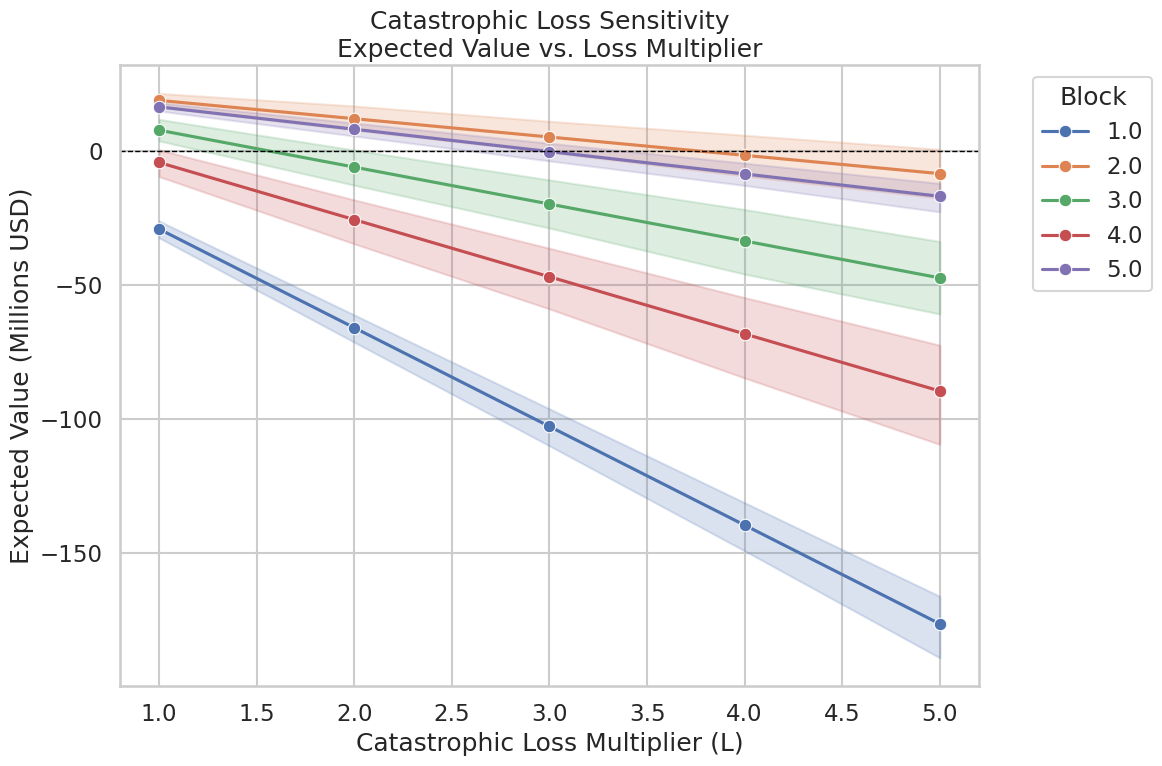

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the folder exists
os.makedirs("figures", exist_ok=True)

sns.set(style="whitegrid", context="talk")

# Prepare data for plotting
plot_df = catastrophic_df.copy()
plot_df["EV_millions"] = plot_df["EV"] / 1e6  # scale for readability

# Create figure + axis explicitly
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    data=plot_df,
    x="LossMultiplier",
    y="EV_millions",
    hue="Block",
    marker="o",
    palette="deep",
    ax=ax
)

ax.axhline(0, color="black", linewidth=1, linestyle="--")

ax.set_title("Catastrophic Loss Sensitivity\nExpected Value vs. Loss Multiplier")
ax.set_xlabel("Catastrophic Loss Multiplier (L)")
ax.set_ylabel("Expected Value (Millions USD)")
ax.legend(title="Block", bbox_to_anchor=(1.05, 1), loc="upper left")

fig.tight_layout()

# Save using the figure object
fig.savefig("figures/orbit_reliability.png", dpi=300, bbox_inches="tight")

plt.show()


**Caption:**
Expected value under varying assumptions about the probability and cost of catastrophic loss. The analysis illustrates how rare, high‑impact failures disproportionately affect reuse economics due to the asymmetric payoff structure. This is a general risk‑management illustration, not a Block‑specific result.

# 10. Conclusion

Falcon 9 Block 5 boosters exhibit high intrinsic landing reliability, reflecting the engineering improvements introduced with the Block 5 upgrade. The hierarchical Bayesian model separates this intrinsic hardware capability from operational reliability, which varies across mission profiles due to differences in orbit class and launch‑site conditions. This distinction is essential for understanding why Block 5 may appear less reliable on certain trajectories despite being the strongest hardware generation.

The economic analysis shows that reuse economics are orbit‑dependent. LEO‑class missions often approach breakeven or positive expected value, while high‑energy missions remain challenging under the assumed payoff structure due to lower operational landing probabilities and higher downside risk. Sensitivity analyses further highlight the asymmetric nature of the payoff structure and the importance of accounting for rare but costly failure scenarios.

Taken together, the modelling and economic framework provide a transparent and statistically principled view of booster reuse. While the results reflect the limits of public data and simplified cost assumptions, the approach is robust and readily extensible to richer engineering or financial information. The analysis demonstrates how separating intrinsic reliability from operational difficulty leads to clearer insight into both performance and economics.

# 11. Future Work

Several extensions could deepen the modelling framework and provide a more comprehensive view of Falcon 9 booster performance and reuse economics. The following directions offer natural next steps:

**Booster‑level random effects**
The current model pools information at the Block level, which captures intrinsic hardware improvements but does not distinguish between individual boosters. Introducing booster‑specific random effects would allow the model to estimate variation across vehicles, quantify booster‑to‑booster heterogeneity, and identify outliers or ageing patterns. This extension requires richer mission‑level metadata but would significantly enhance interpretability.

**Time‑varying reliability**
Landing reliability may evolve over time due to operational learning, procedural changes, or incremental hardware refinements. A time‑varying component—such as a random walk, spline, or Gaussian process—could capture gradual improvements or regressions in landing performance. This would help disentangle long‑term trends from Block‑level effects.

**More detailed cost modelling**
The economic analysis uses simplified payoff assumptions. Incorporating more realistic cost structures—such as variable refurbishment costs, mission‑dependent recovery expenses, or partial‑damage scenarios—would yield a more accurate picture of reuse economics. This could also include modelling uncertainty in cost parameters rather than treating them as fixed values.

**Integration with refurbishment data**
Public data on refurbishment cycles, turnaround times, and component‑level wear is limited, but integrating such information would enable a more complete assessment of lifecycle economics. A joint model of reliability and refurbishment cost could quantify how booster ageing affects both landing probability and financial return.

**Simulation of fleet‑level economics**
A natural extension is to simulate the economics of an entire booster fleet under different launch cadences, mission mixes, and recovery strategies. Combining mission‑level landing probabilities with cost and refurbishment models would allow exploration of long‑term fleet behaviour, optimal reuse strategies, and the economic impact of rare catastrophic events.

# 12. Citations

- SpaceX public launch records  
- PyMC documentation  
- ArviZ documentation  
- McElreath, *Statistical Rethinking*  
- Gelman et al., *Bayesian Data Analysis*
- IBM, Applied Data Science Capstone: SpaceX Falcon 9, Coursera 


# Appendix A — Evolution of the Analysis

This project progressed through several iterations before converging on the final hierarchical Bayesian model. Each stage exposed limitations in earlier approaches and helped refine a more principled and interpretable solution.

**Early Feature Engineering**
The initial analysis explored a wide range of engineered features, including detailed orbit sub‑categories, serial‑number encodings, and mission‑specific configuration flags. While many of these features were informative, they were often sparse, highly correlated, or inconsistently recorded. When included in a classical logistic regression, they produced unstable coefficients and inflated variance.
To avoid overfitting, several features were collapsed into broader categories or removed entirely, leading to a more robust and interpretable feature set.

**Flat Logistic Regression and Model Instability**
The first modelling attempt used a standard logistic regression with Block, orbit, site, and payload mass as predictors. This approach suffered from several structural issues:

- Complete separation in early Blocks, where failures were rare

- Exploding coefficients for Blocks with few observations

- Overconfident predictions, driven by the small and imbalanced dataset

These problems made it clear that a classical, non‑hierarchical approach could not adequately handle the data’s structure or uncertainty.

**Hierarchical Modelling Attempts**
A second attempt introduced Block‑level varying intercepts, but the model initially exhibited severe sampling pathologies due to:

- unscaled payload mass

- overly vague priors

- centred parameterisation of Block effects

Switching to a standardised mass, weakly informative priors, and a non‑centred parameterisation resolved the divergences and produced stable, well‑behaved posterior samples. This marked the transition to a fully hierarchical framework capable of pooling information across Blocks while preserving meaningful differences.

**Correcting the Economic Model**
The first economic analysis used a symmetric breakeven formula that treated upside and downside as equal. This was incorrect.
Introducing a proper asymmetric‑risk formulation revealed that breakeven reliability was substantially lower than originally estimated and that expected value depends primarily on operational landing probability, not intrinsic Block‑level reliability.
This correction fundamentally changed the interpretation of reuse economics and aligned the financial analysis with the hierarchical model.

**Final Convergence**
The final model — a hierarchical Bayesian logistic regression with collapsed categorical predictors and standardised mass — proved stable, interpretable, and consistent with the physics of Falcon 9 missions. It provided uncertainty‑aware, mission‑specific landing probabilities and the correct inputs for an orbit‑dependent economic analysis.

**Summary**
The iterative development process strengthened the final result. Each discarded idea clarified the limitations of simpler approaches and contributed to a more defensible modelling framework. The final analysis reflects a balance between statistical rigour, physical intuition, and the constraints of publicly available data.

# Appendix B -- Methodology

This project combines hierarchical Bayesian modelling with an asymmetric‑risk economic framework to estimate Falcon 9 booster landing reliability and evaluate the financial viability of reuse. The methodology is designed to balance statistical rigour with the practical constraints of publicly available data.

**Data and Feature Construction**

The dataset consists of publicly documented Falcon 9 missions, including landing outcomes, Block generation, orbit class, launch site, and payload mass. To avoid overfitting and instability in sparse categories, several features were collapsed into broader, interpretable groups:

- Block: 1–5

- Orbit class: LEO‑class, High‑Energy, Other

- Launch site: grouped into major recovery locations

- Payload mass: standardised to zero mean and unit variance

This structure preserves the key sources of variation while ensuring sufficient data within each category.

**Hierarchical Bayesian Model**

Landing reliability is modelled using a hierarchical Bayesian logistic regression. The model includes:

- Block‑level varying intercepts to capture intrinsic hardware reliability

- Orbit‑level and site‑level effects to represent operational mission difficulty

- A standardised payload‑mass term to account for mission‑specific performance constraints

The hierarchical structure enables partial pooling, allowing Blocks with limited data to borrow strength from the overall distribution while still reflecting meaningful differences.

A non‑centred parameterisation is used for all hierarchical effects to ensure stable sampling. Weakly informative priors constrain the parameter space and prevent pathological posteriors, particularly in categories with few observations.

Posterior inference is performed using Hamiltonian Monte Carlo, providing full uncertainty quantification for both intrinsic and operational reliability.

**Mission‑Specific Landing Probabilities**

The model produces posterior distributions for the probability of a successful landing on each mission. These probabilities incorporate:

- intrinsic Block capability

- orbit‑specific difficulty

- site‑specific recovery conditions

- mission‑level payload mass

This allows the analysis to distinguish between intrinsic reliability (hardware capability) and operational reliability (mission difficulty), a key conceptual contribution of the project.

**Economic Analysis**

Expected value (EV) is computed using an asymmetric payoff structure:

- Successful landing: +$30 M hardware value

- Failed recovery: –$50 M loss

The breakeven landing probability is derived directly from this payoff structure and is independent of the Bayesian model. Expected value is evaluated by orbit class, reflecting the fact that operational reliability varies primarily with mission profile rather than Block generation.

Sensitivity analyses explore how EV responds to changes in landing probability, cost assumptions, and rare catastrophic events. These analyses are conceptual tools, illustrating the economic landscape rather than representing Block‑specific predictions.

**Model Validation and Diagnostics**

Model performance is assessed through:

- posterior predictive checks

- inspection of hierarchical shrinkage behaviour

- convergence diagnostics (R‑hat, effective sample size)

- examination of residual structure and predictive uncertainty

These diagnostics confirm that the final model is stable, interpretable, and consistent with the physical constraints of Falcon 9 missions.

**Summary**

The methodology integrates hierarchical Bayesian inference with a principled economic framework to provide a transparent, uncertainty‑aware assessment of Falcon 9 booster reuse. The approach is robust to sparse data, aligned with the physics of launch and recovery, and extensible to richer engineering or financial information.

## Appendix C -- Lessons Learned

Several themes emerged during the development of this project, each shaping the final modelling and economic framework:

**Simplicity outperforms complexity when data are limited**

Early versions of the model included numerous engineered features, many of which were sparse, correlated, or inconsistently recorded. These additions increased variance without improving insight. Collapsing categories and focusing on interpretable predictors produced a more stable and defensible model.

**Hierarchical models solve problems that classical methods cannot**

Flat logistic regression struggled with complete separation, exploding coefficients, and overconfident predictions. Hierarchical partial pooling handled these issues naturally, stabilising estimates and providing realistic uncertainty for Blocks with limited data.

**Good priors prevent bad posteriors**

Overly vague priors led to divergences and unstable sampling behaviour. Introducing weakly informative priors, together with a non‑centred parameterisation, dramatically improved sampler performance and produced well‑behaved posteriors.

**Scaling is essential, not optional**

Unscaled payload mass created pathological posterior geometry and hindered convergence. Standardising continuous predictors proved critical for reliable inference in Bayesian logistic regression.

**Economic models must reflect asymmetric risk**

The initial breakeven analysis assumed symmetric upside and downside, leading to misleading conclusions. Incorporating asymmetric payoffs revealed a much lower breakeven reliability and clarified why reuse economics depend primarily on operational landing probability.

**Iteration is not wasteful**

Many early attempts were discarded, but each failure clarified the structure of the problem and guided the model toward a more principled solution. The final framework is stronger precisely because of the paths that did not succeed.